In [1]:
import pandas as pd
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import re
plt.style.use('ggplot')

In [2]:
t10 = pd.read_csv("t102.csv")

In [45]:
t10.shape

(37985, 17)

In [4]:
made_lst = list(t10.groupby("made").groups.keys())

In [6]:
def getdf (brand):
    e = t10.loc[t10['made'] == brand][['age', 'mileage', 'price', 'model']]
    e = e[e.groupby("age").price.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
    e = e[e.groupby("age").mileage.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
    e = pd.get_dummies(e)
    e = e.assign(agesqurt = e.age**2)
    return e

In [214]:
Hyundai = getdf("Hyundai")

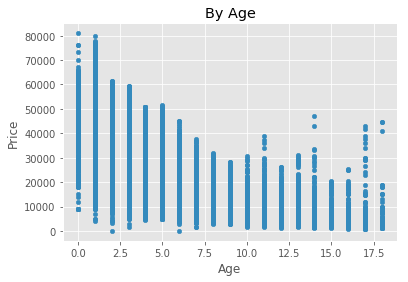

In [354]:
t10.plot.scatter(x = "age", y = "price")
plt.xlabel("Age")
plt.ylabel("Price")
plt.title("By Age")
plt.savefig("plots/byear.pdf")

In [7]:
t10half = t10.loc[t10["made"].isin(made_lst[0:5])]
t10half2 = t10.loc[t10["made"].isin(made_lst[5:10])]

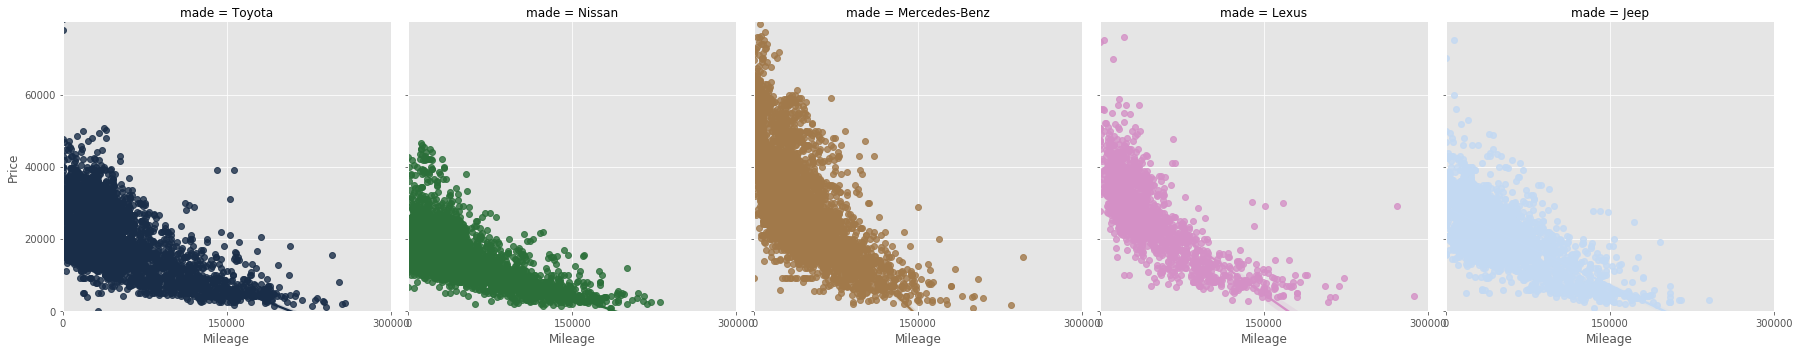

In [169]:
g = sns.lmplot("mileage", "price", t10half2, hue = "made", col = "made", palette = "cubehelix")
g = (g.set_axis_labels("Mileage", "Price").set(xlim=(0, 300000), ylim=(0,80000), xticks=[0,150000,300000], 
                                            yticks=[0,20000,40000,60000]))
g.savefig("plots/bymile2.pdf")

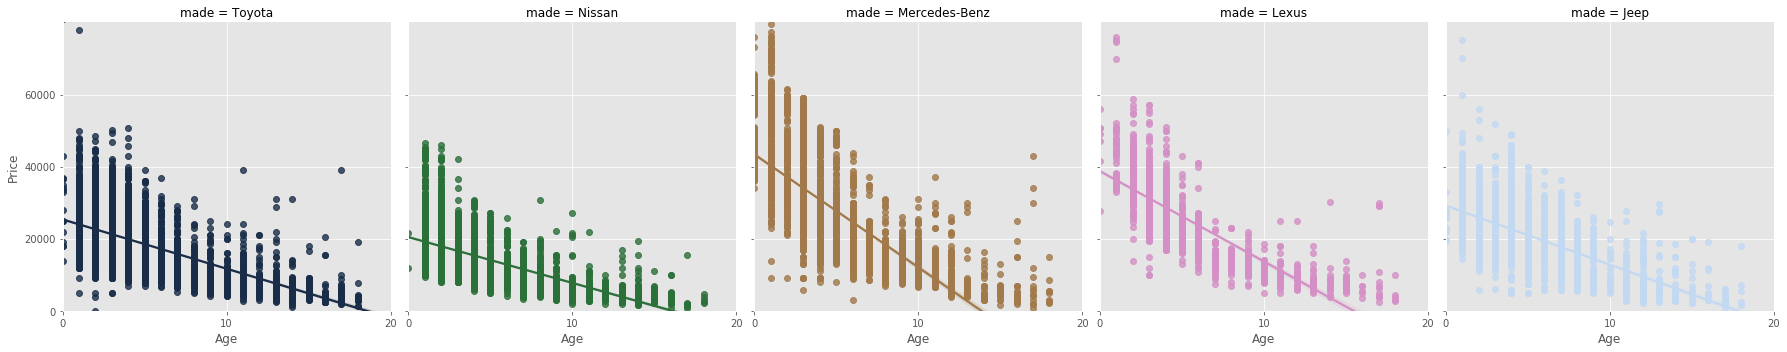

In [9]:
y = sns.lmplot("age", "price", t10half2, hue = "made", col = "made", palette = "cubehelix", fit_reg = True)
y = (y.set_axis_labels("Age", "Price").set(xlim=(0,20), ylim=(0,80000), xticks=[0,10,20], 
                                            yticks=[0,20000,40000,60000]))
plt.savefig("byear2.pdf")

In [32]:
def getmodel (brand):
    e = t10.loc[t10['made'] == brand][['age', 'mileage', 'price', 'model']]
    e = e[e.groupby("age").price.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
    e = e[e.groupby("age").mileage.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
    e = pd.get_dummies(e)
    X = e.drop("price", axis = 1)
    X = X.assign(agesqrt = X.age**2)
    y = e['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    return model.score(X_test, y_test), model.coef_[0]

In [33]:
def getmodel_wopower (brand):
    e = t10.loc[t10['made'] == brand][['age', 'mileage', 'price', 'model']]
    e = e[e.groupby("age").price.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
    e = e[e.groupby("age").mileage.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
    e = pd.get_dummies(e)
    X = e.drop("price", axis = 1)
    y = e['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    return model.score(X_test, y_test), model.coef_[0]

In [13]:
getmodel("Toyota")

(0.8078708956525653, -1179.760992051941)

In [14]:
getmodel_woagesqrt("Honda")

(0.808632193039041, -952.576910361234)

In [40]:
lm_dc = {}
for i, e in enumerate(made_lst):
    lm_dc.update({made_lst[i]:[round(n,2) for n in getmodel(e)]})
lmnp_dc = {}
for i, e in enumerate(made_lst):
    lmnp_dc.update({made_lst[i]:[round(n,2) for n in getmodel_wopower(e)]})

In [42]:
lm_df = pd.DataFrame.from_dict(lm_dc, orient = 'index', columns = ["R Squrt", "Age's Coefficient"])
lmnp_df = pd.DataFrame.from_dict(lmnp_dc, orient = 'index', columns = ["R Squrt", "Age's Coefficient"])

In [43]:
lm_df.sort_values(by="Age's Coefficient", ascending = False)

,R Squrt,Age's Coefficient
Hyundai,0.74,-470.06
Nissan,0.79,-1176.49
Toyota,0.81,-1202.52
Jeep,0.77,-1476.99
Ford,0.77,-1712.38
Chevrolet,0.83,-1731.46
Honda,0.83,-2200.26
Lexus,0.87,-4866.70
Mercedes-Benz,0.86,-5346.32
BMW,0.88,-5882.75


In [44]:
lmnp_df.sort_values(by="Age's Coefficient", ascending = False)

,R Squrt,Age's Coefficient
Hyundai,0.74,-551.90
Nissan,0.79,-708.47
Toyota,0.81,-852.42
Chevrolet,0.83,-947.44
Honda,0.81,-952.58
Jeep,0.77,-997.52
Ford,0.77,-1053.36
Lexus,0.82,-1671.54
BMW,0.85,-2077.82
Mercedes-Benz,0.83,-2522.12


In [158]:
EDA_df = t10.groupby("made")[["price", "mileage"]].mean().round(2).sort_values(by="price", ascending = False)

In [262]:
t10 = t10.dropna(subset = ["drive"])

In [332]:
X = t10.drop(["price","exter","drive","model", "cty", "eng","fuel","cty", "hwy", "title","tran","year", 
              "inter", "slrzip","slreview"], axis = 1)

In [333]:
X = pd.get_dummies(X)

In [335]:
X = X.assign(Chevrolet = X.age*X.made_Chevrolet,BMW = X.age*X.made_BMW, Ford = X.age*X.made_Ford,
             Honda = X.age*X.made_Honda,Hyundai = X.age*X.made_Hyundai,Jeep = X.age*X.made_Jeep,
             Lexus = X.age*X.made_Lexus,MB = X.age*X["made_Mercedes-Benz"],
             Nissan = X.age*X.made_Nissan,Toyota = X.age*X.made_Toyota)

In [275]:
X = X.assign(agesqurt = X.age**2)

In [337]:
y = t10["price"]

In [282]:
X = pd.get_dummies(X,drop_first=True)

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [339]:
model = sm.OLS(y_train,X_train).fit()

In [340]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2127.
Date:                Mon, 11 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:23:50   Log-Likelihood:            -3.1324e+05
No. Observations:               30388   AIC:                         6.265e+05
Df Residuals:                   30367   BIC:                         6.267e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
mileage               -0.0901      0.002    -48.209      0.000      -0.094      -0.086
age                 -954.9088     20.355    -46.912      0.000    -994.806    -915.011
made_BMW            4.283e+04    205.097    208.847      0.000    4.24e+04    4.32e+04
made_Chevrolet      2.796e+04    211.235    132.382      0.000    2.75e+04    2.84e+04
made_Ford           2.827e+04    193.132    146.396      0.000    2.79e+04    2.87e+04
made_Honda          2.397e+04    201.113    119.200      0.000    2.36e+04    2.44e+04
made_Hyundai        1.909e+04    317.249     60.185      0.000    1.85e+04    1.97e+04
made_Jeep           2.966e+04    257.227    115.297      0.000    2.92e+04    3.02e+04
made_Lexus          3.908e+04    340.370    114.807      0.000    3.84e+04    3.97e+04
made_Mercedes-Benz  4.401e+04    208.916    210.674      0.000    4.36e+04    4.44e+04
made_Nissan         2.123e+04    193.385    109.785      0.000    2.09e+04    2.16e+04
made_Toyota         2.582e+04    192.630    134.058      0.000    2.54e+04    2.62e+04
Chevrolet            181.1605     37.320      4.854      0.000     108.011     254.310
BMW                -1397.3432     37.501    -37.262      0.000   -1470.846   -1323.841
Ford                 151.2959     32.334      4.679      0.000      87.920     214.672
Honda                441.8070     34.050     12.975      0.000     375.067     508.547
Hyundai              657.6992     60.556     10.861      0.000     539.006     776.392
Jeep                 183.8798     45.441      4.047      0.000      94.813     272.946
Lexus               -741.0394     54.993    -13.475      0.000    -848.828    -633.250
MB                 -1419.0298     37.790    -37.550      0.000   -1493.100   -1344.960
Nissan               535.9348     38.253     14.010      0.000     460.958     610.912
Toyota               450.7263     33.758     13.352      0.000     384.560     516.893
==============================================================================
Omnibus:                     6073.091   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15285.403
Skew:                           1.102   Prob(JB):                         0.00
Kurtosis:                       5.686   Cond. No.                     1.23e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.3e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [353]:
model.params[12:].sort_values(ascending = False)

Hyundai       657.699247
Nissan        535.934827
Toyota        450.726325
Honda         441.806990
Jeep          183.879779
Chevrolet     181.160472
Ford          151.295923
Lexus        -741.039369
BMW         -1397.343190
MB          -1419.029772
dtype: float64